<h1> Assignment 3: Group Project </h1>

In [53]:
# import libraries

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import re

# 1. Data preparation and exploration

## 1.1 Data Retrieving

In [54]:
movies_df = pd.read_csv('data/movies.csv', delimiter=',')
ratings_df = pd.read_csv('data/ratings.csv', delimiter=',')

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [56]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1.425942e+09
1,1,147,4.5,1.425942e+09
2,1,858,5.0,1.425942e+09
3,1,1221,5.0,1.425942e+09
4,1,1246,5.0,1.425942e+09


## 1.2 Data cleaning and preparation

In [57]:
# Create orginal data frame for backup
movies_df_raw = movies_df.copy()
ratings_df_raw = ratings_df.copy()

In [58]:
#set threshold
threshold = 0.65

# dropping columns with missing value rate higher than threshold
ratings_df = ratings_df[ratings_df.columns[ratings_df.isnull().mean() < threshold]]

# Remove the missing values from the rows having greater or equal to 6 missing values.
movies_df = movies_df[movies_df.isnull().sum(axis=1) <= 6]
ratings_df = ratings_df[ratings_df.isnull().sum(axis=1) <= 6]

### 1.2.1 Handle missing data

In [59]:
# Filling missing value for movies dataset

movies_df["tagline"] = movies_df["tagline"].fillna("Unknown")

movies_df["overview"] = movies_df["overview"].fillna("Unknown")

movies_df["poster_path"] = movies_df["poster_path"].fillna("Unknown")

movies_df["runtime"] = movies_df["runtime"].fillna(method='ffill')

movies_df["release_date"] = movies_df["release_date"].fillna(method='ffill')

movies_df["status"] = movies_df["status"].fillna(movies_df['status'].mode()[0])

movies_df["imdb_id"] = movies_df["imdb_id"].fillna("imdb_id")

movies_df["original_language"] = movies_df["original_language"].fillna(movies_df['original_language'].mode()[0])

In [60]:
# Movies dataset
percent_missing = movies_df.isnull().sum() * 100 / len(movies_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
belongs_to_collection,90.121447
homepage,82.887442
adult,0.000000
production_countries,0.000000
vote_average,0.000000
video,0.000000
title,0.000000
tagline,0.000000
status,0.000000
spoken_languages,0.000000


## ????

In [61]:
# Ratings dataset
percent_missing = ratings_df.isnull().sum() * 100 / len(ratings_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
rating,0.000486
timestamp,0.000486
userId,0.000000
movieId,0.000000


In [62]:
# rename column id in movies_df to match movieId with ratings_df
movies_df.rename(columns={"id": "movieId"}, inplace=True)

In [63]:
# Check type for movies_df
movies_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
movieId                   object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [64]:
# Check type for ratings_df
ratings_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp    float64
dtype: object

In [65]:
# Delete row in movieId column contain string value
movies_df = movies_df[~movies_df['movieId'].isin(['1997-08-20', '2012-09-29','2014-01-01'])]

In [66]:
# change column type for movies_df
movies_df["movieId"] = pd.to_numeric(movies_df["movieId"])

movies_df['popularity'] = movies_df['popularity'].astype(float)

movies_df['budget'] = movies_df['budget'].astype(float)

In [67]:
ratings_df = ratings_df.groupby(['movieId']).mean().groupby('movieId')['rating'].mean().reset_index()

In [68]:
df = movies_df.merge(ratings_df, how="left", on="movieId")

comment_counts = pd.DataFrame(df["title"].value_counts())
rare_movies = comment_counts[comment_counts["title"] <= 1000].index
common_movies = df[~df["title"].isin(rare_movies)]
# round rating float, for classification
df = df.round({'rating': 0})

In [69]:
from ast import literal_eval

def split_genres(row):
    row['genres'] = ",".join([info['name'] for info in literal_eval(row['genres'])])
    return row

def split_prod_countries(row):
    row['production_countries'] = ",".join([info['name'] for info in literal_eval(row['production_countries'])])
    return row

def split_prod_companies(row):
    row['production_companies'] = ",".join([info['name'] for info in literal_eval(row['production_companies'])])
    return row

def split_spoken_languages(row):
    row['spoken_languages'] = ",".join([info['name'] for info in literal_eval(row['spoken_languages'])])
    return row
  
df = df.apply(split_genres, axis=1)
df = df.apply(split_prod_countries, axis=1)
df = df.apply(split_prod_companies, axis=1)
df = df.apply(split_spoken_languages, axis=1)

In [70]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    # remove whitespaces
    text = ' '.join(text.split())
    # remove double whote inside
    text = text.replace('“', '').replace('”', '').replace('"', '')
    # remove number
    text = re.sub(r"\d+", "", text)
    # convert text to lowercase
    text = text.lower()
    
    return text

In [71]:
# Apply clean_text function for cleaning text
df['title'] = df['title'].apply(lambda x: clean_text(x))
df['tagline'] = df['tagline'].apply(lambda x: clean_text(x))
df['original_title'] = df['original_title'].apply(lambda x: clean_text(x))
df['overview'] = df['overview'].apply(lambda x: clean_text(x))

In [72]:
# Remove stopword
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
df['overview'] = df['overview'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.3 Data Exploration

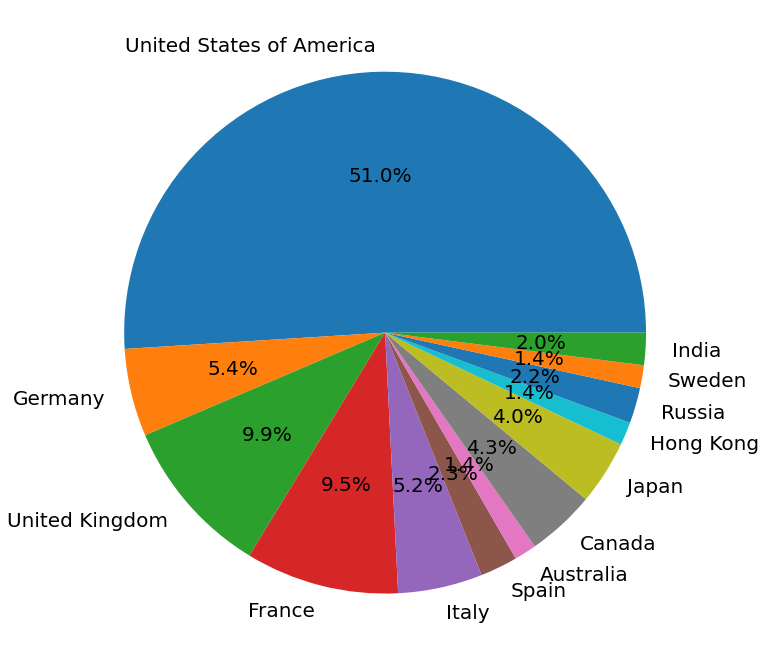

In [73]:
from collections import Counter

a=[]
for each in df.production_countries.str.split(","):
    for i in each:
        a.append(i)
        
b = dict(Counter(a))

keys=[]
values=[]

for key,value in b.items() :
    if value > 500 and key != "":
        keys.append(key)
        values.append(value)

       
labels = keys
colors = sns.color_palette()
explode =[0,0,0,0,0,0,0,0,0,0,0,0,0]
sizes= values
    
plt.figure(figsize = (20,12))

plt.pie(sizes,explode = explode,labels=labels,colors = colors,autopct='%1.1f%%',textprops= {"fontsize": 20},shadow = False)

plt.show()

Text(0.5, 1.0, 'Number of movie types')

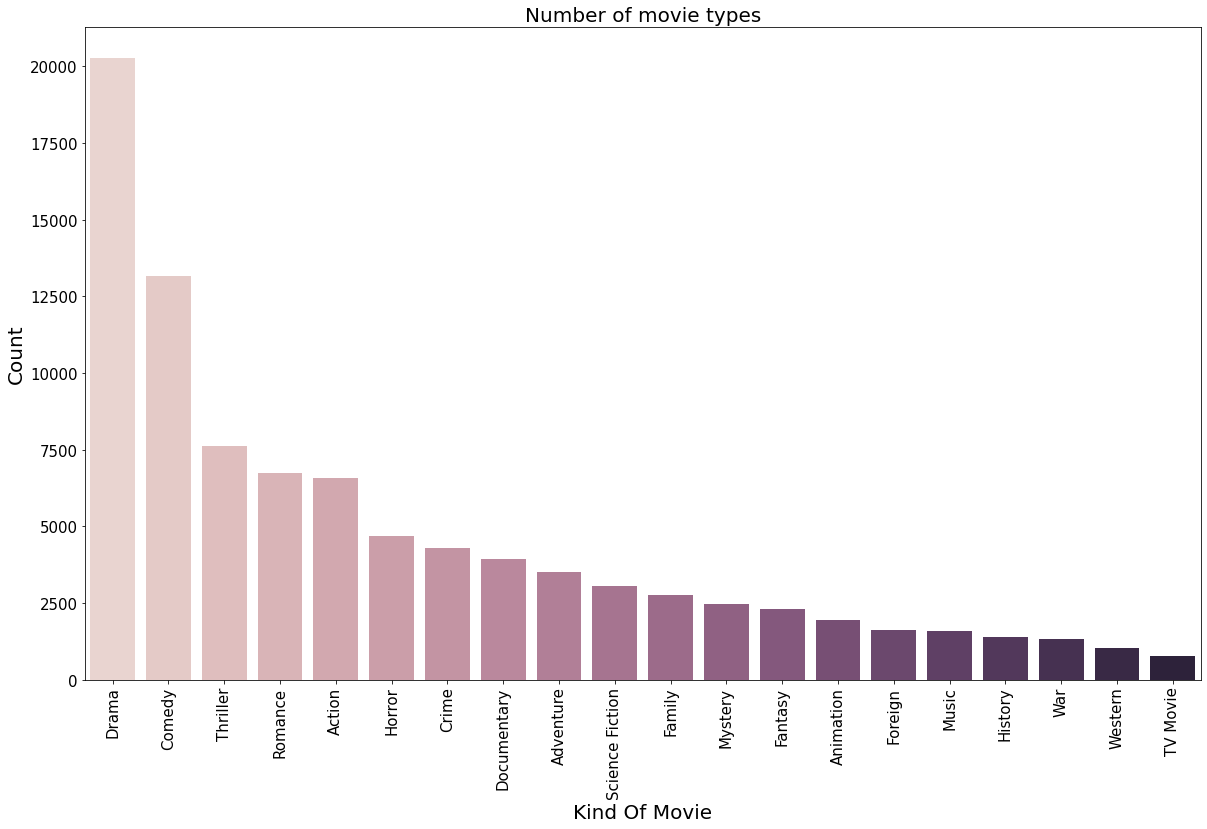

In [74]:
from collections import Counter

data = df.genres.copy()

list_kind = data.str.split(",")
a = []
for each in list_kind:
    for i in each:
        a.append(i)
        
c=[]
for each in a:
    if each != "":
         c.append(each)        
        
f= dict(Counter(c))

df3 = pd.DataFrame(list(f.items()),columns = ["kind","ratio"])
new_index =( df3.ratio.sort_values(ascending=False)).index.values
new = df3.reindex(new_index)

plt.figure( figsize = (20,12))
plt.tick_params(labelsize = 15)
sns.barplot(x="kind",y="ratio",data=new,palette = sns.cubehelix_palette(len(f)))
plt.xticks(rotation = 90)
plt.xlabel("Kind Of Movie",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.title("Number of movie types",fontsize = 20)

<ipython-input-75-565858821330>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


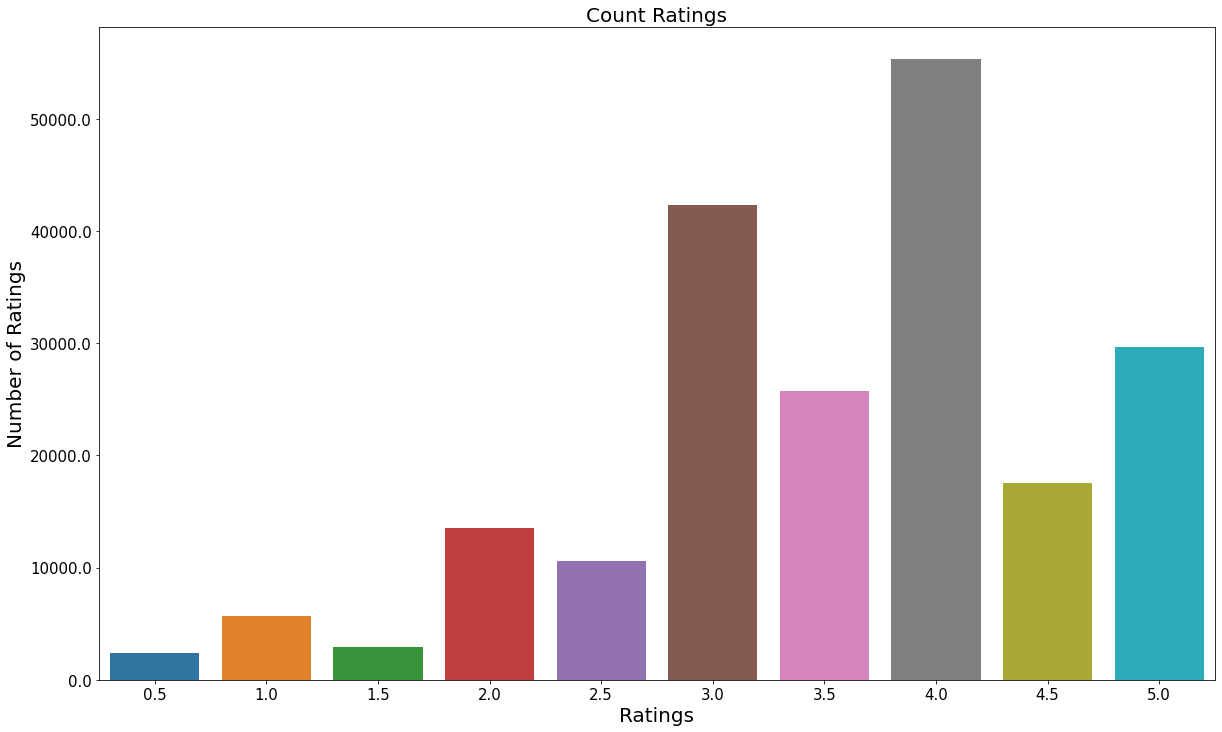

In [75]:
f,ax = plt.subplots(1,1,figsize=(20,12))
ax = sns.countplot(x="rating", data=ratings_df_raw)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Popular Movies')

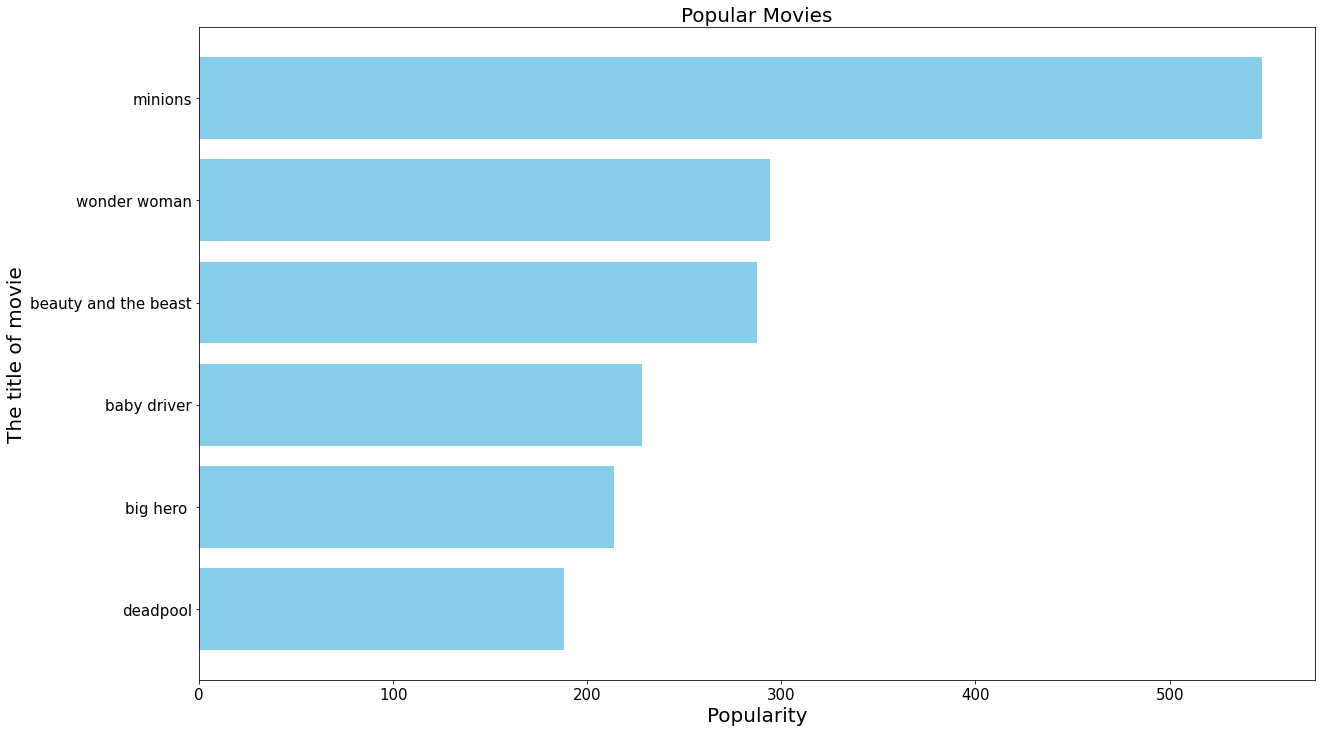

In [76]:
pop = df.sort_values('popularity', ascending=False)
plt.figure(figsize=(20,12))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.tick_params(labelsize = 15)
plt.xlabel("Popularity", fontsize = 20)
plt.ylabel("The title of movie", fontsize = 20)
plt.title("Popular Movies", fontsize = 20)

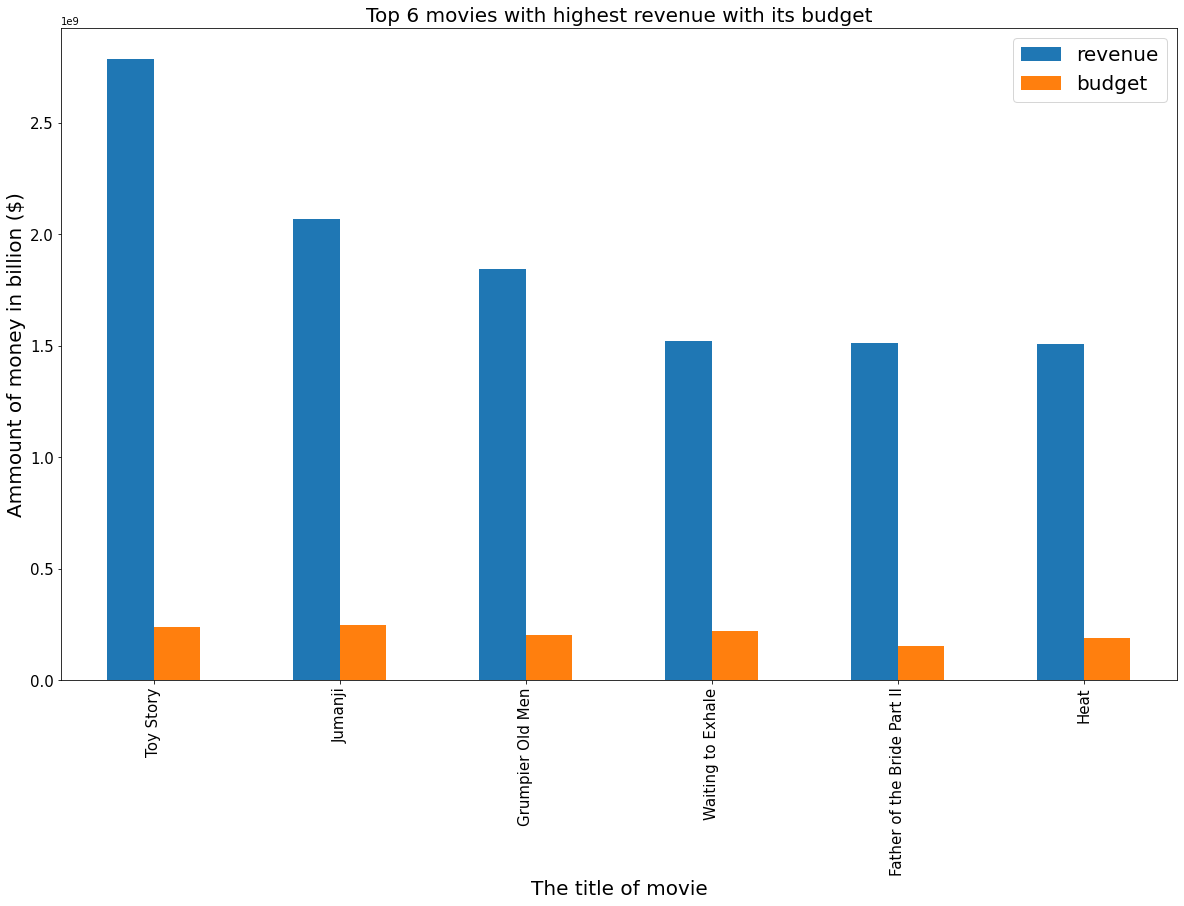

In [77]:
df1 = movies_df[['title','revenue','budget']].copy()

df1.set_index('title', inplace=True)

ax = df1.sort_values(by=['revenue'], ascending=False).head(6).plot(kind='bar', figsize=(20,12))
ax.xaxis.set_major_formatter(plt.FixedFormatter(df1.index.to_series()))
plt.tick_params(labelsize = 15)
plt.ylabel("Ammount of money in billion ($)", fontsize = 20)
plt.xlabel("The title of movie", fontsize = 20)
plt.legend(fontsize=20)
plt.title("Top 6 movies with highest revenue with its budget", fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Most popular language in movies')

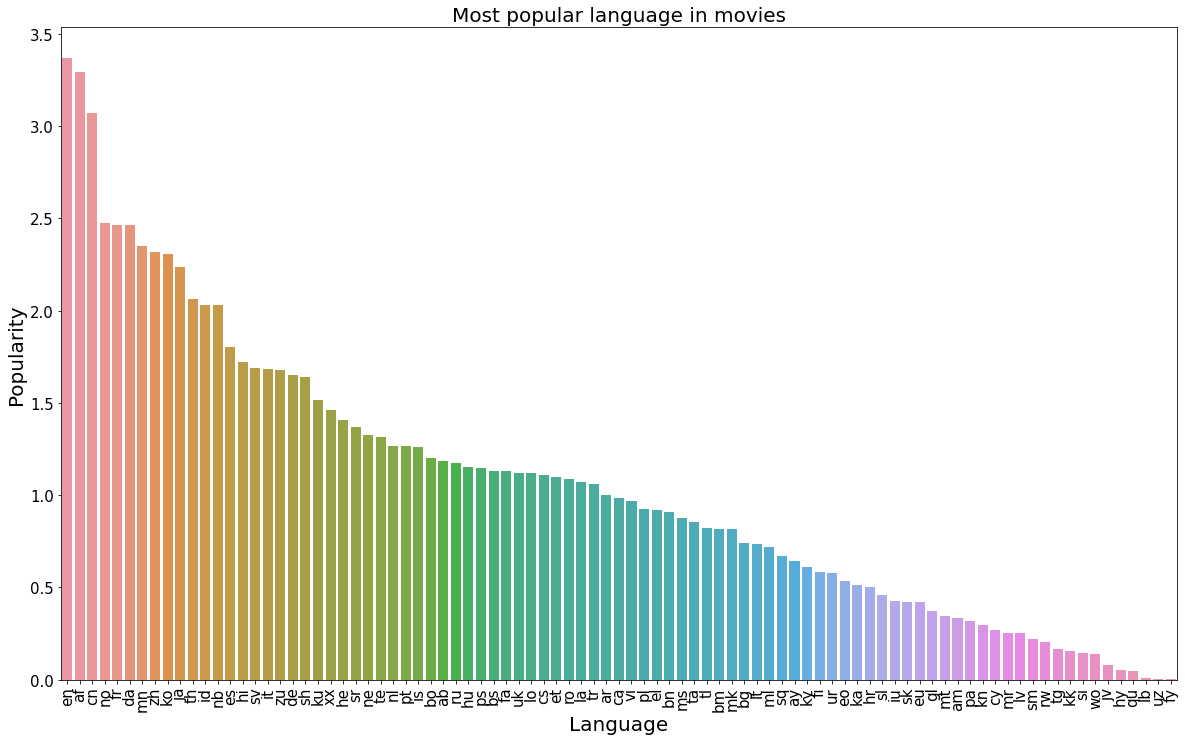

In [78]:
unique = list(movies_df.original_language.unique())
list_ratio=[]
for each in unique:
    x= movies_df[movies_df["original_language"] == each]
    ratio_popularity=sum(x.popularity)/len(x)
    list_ratio.append(ratio_popularity)
    
df1 = pd.DataFrame({"language":unique,"ratio":list_ratio})
new_index = (df1.ratio.sort_values(ascending = False)).index.values
sorted_data= df1.reindex(new_index)

#Visualization
plt.figure(figsize = (20,12))
sns.barplot(x= sorted_data["language"],y  = sorted_data["ratio"])
plt.xticks(rotation= 90)
plt.tick_params(labelsize = 15)

plt.xlabel("Language",fontsize = 20)
plt.ylabel("Popularity",fontsize = 20)
plt.title("Most popular language in movies", fontsize = 20)

# 2. Data Modelling
---

## Categorical Encoding

**belongs_to_collection**


Convert column 'belongs_to_collection' data to binary data of 0 and 1 (1 means the movie belongs to a collection, and 0 means it does not belong to any collection).

In [79]:
# converting column 'belongs_to_collection' to binary 0 and 1 data
df["belongs_to_collection"] = df["belongs_to_collection"].fillna(0)
df["belongs_to_collection"] = np.where(df["belongs_to_collection"] != 0,1,0)
df['belongs_to_collection'] = pd.to_numeric(df['belongs_to_collection'])

**homepage**

Convert column 'homepage' to binary data of 0 and 1 (1 means the movie has a homepage, and 0 means the movie does not have a homepage)

In [80]:
df["homepage"] = df["homepage"].fillna(0)
df["homepage"] = np.where(df["homepage"] != 0,1,0)
df['homepage'] = pd.to_numeric(df['homepage'])

**adult**

Convert column 'adult' data from boolean value to 1 and 0 (1: True, 0: False)

In [81]:
df["adult"] = np.where(df['adult'] == True, 1, 0)
df['adult'] = pd.to_numeric(df['adult'])

**video**

Convert column 'video' data from boolean value to 1 and 0 (1: True, 0: False)

In [82]:
df["video"] = np.where(df['video'] == True, 1, 0)
df['video'] = pd.to_numeric(df['video'])

**status**

In [83]:
df['status'].value_counts()

Released           45087
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

Since "Released" is the dominant value in this column, we can make the dataset easier for computing by replacing value "Released" with 1, and the others with 0.

In [84]:
df["status"] = np.where(df['status'] == True, 1, 0)
df['status'] = pd.to_numeric(df['status'])

**spoken_languages**

In [85]:
df['spoken_languages'].value_counts()

English                                             22395
                                                     3945
Français                                             1852
日本語                                                  1289
Italiano                                             1218
                                                    ...  
English,,Tiếng Việt                                     1
Eesti,svenska                                           1
suomi,Português                                         1
Français,हिन्दी,English                                 1
Deutsch,English,Français,हिन्दी,Türkçe,广州话 / 廣州話        1
Name: spoken_languages, Length: 1842, dtype: int64

Same with column 'status', English is the most common language used in the movies. In addition, it also dominate other languages in terms of quantity. Therefore, we can set value 1 for movies that has English as one of the spoken language, and 0 when the movie does not use English.

In [86]:
df["spoken_languages"] = np.where(df['spoken_languages'].str.contains("English"), 1, 0)
df['spoken_languages'] = pd.to_numeric(df['spoken_languages'])

**original_language**

In [87]:
df['original_language'].value_counts()

en    32278
fr     2437
it     1529
ja     1349
de     1078
      ...  
sm        1
qu        1
cy        1
rw        1
mt        1
Name: original_language, Length: 89, dtype: int64

In [88]:
df["original_language"] = np.where(df['original_language'] == "en", 1, 0)
df['original_language'] = pd.to_numeric(df['original_language'])

**production_countries**

In [89]:
df['production_countries'].value_counts()

United States of America                               17851
                                                        6276
United Kingdom                                          2238
France                                                  1653
Japan                                                   1356
                                                       ...  
Denmark,Mexico                                             1
Croatia,France,Slovenia,Serbia                             1
Italy,North Korea                                          1
Italy,Spain,United Kingdom,United States of America        1
Spain,United States of America,Colombia                    1
Name: production_countries, Length: 2390, dtype: int64

From a real world perspective, we can observe that the US's movie industry is gigantic. From this standpoint, we can set value of 1 for movies that involved the US in the production phase, and 0 for ther others.

In [90]:
df["production_countries"] = np.where(df['production_countries'].str.contains("United States of America"), 1, 0)
df['production_countries'] = pd.to_numeric(df['production_countries'])

**genres**

In [91]:
genre_list = []
for value in df['genres'].unique():
  value_list = value.split(',')
  for item in value_list:
    genre_list.append(item)

genre_list = np.unique(np.array(genre_list)).tolist()
genre_list.remove("")

for genre in genre_list:
  column_name = 'genres_' + genre
  df[column_name] = np.where(df['genres'].str.contains(genre), 1, 0)
    
df.drop("genres",axis=1,inplace=True)

**production_companies** (consideration)

In [92]:
company_list = []
for value in df['production_companies'].unique():
  value_list = value.split(',')
  for item in value_list:
    company_list.append(item)

company_list = np.unique(np.array(company_list)).tolist()
company_list.remove("")

for company in company_list:
  column_name = 'production_companies_' + company
#   df[column_name] = np.where(df['production_companies'].str.contains(company), 1, 0)

**release_date**

To use a datetime feature for fitting into a machine learning model, we can extract cyclical features (day, month) and encode them using sine and cosine transformation. This is to ensure that the data still keeps there cyclinal nature.
https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

In [93]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [94]:
df['release_date']= pd.to_datetime(df['release_date'])
df['month'] = df.release_date.dt.month
df['day'] = df.release_date.dt.dayofyear

print(df['day'])

0        303
1        349
2        356
3        356
4         41
        ... 
45447    133
45448    321
45449    213
45450    294
45451    160
Name: day, Length: 45452, dtype: int64


In [95]:
df = encode(df, 'month', 12)
df = encode(df, 'day', 365)

## 2.1 Feature Engineering

Feature selection for fitting into the machine learning algorithms

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45452 entries, 0 to 45451
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   adult                   45452 non-null  int32         
 1   belongs_to_collection   45452 non-null  int32         
 2   budget                  45452 non-null  float64       
 3   homepage                45452 non-null  int32         
 4   movieId                 45452 non-null  int64         
 5   imdb_id                 45452 non-null  object        
 6   original_language       45452 non-null  int32         
 7   original_title          45452 non-null  object        
 8   overview                45452 non-null  object        
 9   popularity              45452 non-null  float64       
 10  poster_path             45452 non-null  object        
 11  production_companies    45452 non-null  object        
 12  production_countries    45452 non-null  int32 

#### 2.1.1 Reasoning

In [97]:
df['adult'].value_counts()

0    45452
Name: adult, dtype: int64

Because column 'adult' only contains 1 value (False), we can remove this feature from the dataset. Also, from a reality perspective, we can also drop other columns that does not predict the rating of a movies:
- imdb_id: id of the movie on imdb film review site
- movieId: id of the movie in the dataset
- poster_path: url to the poster of the movie
- original_title, title: name of the movie before and after release
- overview: a brief description about the movie
- tagline: the movie quote (usually in posters)

In [98]:
df.drop(['adult','imdb_id','poster_path','title','original_title','overview','movieId','tagline'], axis=1, inplace=True)

In [99]:
first_column = df.pop('rating')
df.insert(0, 'rating', first_column)
df.head()

,rating,belongs_to_collection,budget,homepage,original_language,popularity,production_companies,production_countries,release_date,revenue,...,genres_TV Movie,genres_Thriller,genres_War,genres_Western,month,day,month_sin,month_cos,day_sin,day_cos
0,4.0,1,30000000.0,1,1,21.946943,Pixar Animation Studios,1,1995-10-30,373554033.0,...,0,0,0,0,10,303,-8.660254e-01,0.5,-0.875892,0.482508
1,NaN,0,65000000.0,0,1,17.015539,"TriStar Pictures,Teitler Film,Interscope Commu...",1,1995-12-15,262797249.0,...,0,0,0,0,12,349,-2.449294e-16,1.0,-0.271958,0.962309
2,NaN,1,0.0,0,1,11.712900,"Warner Bros.,Lancaster Gate",1,1995-12-22,0.0,...,0,0,0,0,12,356,-2.449294e-16,1.0,-0.154309,0.988023
3,NaN,0,16000000.0,0,1,3.859495,Twentieth Century Fox Film Corporation,1,1995-12-22,81452156.0,...,0,0,0,0,12,356,-2.449294e-16,1.0,-0.154309,0.988023
4,NaN,1,0.0,0,1,8.387519,"Sandollar Productions,Touchstone Pictures",1,1995-02-10,76578911.0,...,0,0,0,0,2,41,8.660254e-01,0.5,0.648630,0.761104


In [100]:
df['rating'].value_counts()

4.0    1455
3.0    1177
2.0     386
5.0      74
1.0      43
0.0      18
Name: rating, dtype: int64

Chi square

In [101]:
from sklearn.feature_selection import chi2

X = df.drop('rating',axis=1)
Y = df['rating']
chi_scores = chi2(X,Y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

ValueError: could not convert string to float: 'Pixar Animation Studios'

#### 2.1.2 Correlation Matrix

In [ ]:
f,ax = plt.subplots(figsize = (20,12))
sns.heatmap (df.corr(), annot = True,linewidths =0.75,linecolor = "White",fmt = ".2f",ax = ax,center = -0.1)
plt.show()

### 2.2 K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

kf5 = KFold(n_splits=5, shuffle=False)

### 2.3 Parameter tuning

### 2.4 Model training

### 2.5 Model Evaluation and Selection

### 2.6 Save the model for deployment

In this task, we use Pickle to save and load the model. Since in order to use the model outside of the notebook, we need to sae it - and then later, we can load and use it for deployment 

In [ ]:
import pickle

In [ ]:
# pickle.dump(model1, open('model1.pkl', 'wb'))
# pickle.dump(model2, open('model2.pkl', 'wb'))
# pickle.dump(model3, open('model3.pkl', 'wb'))

## 3. Model deployment and Automation

## 4. Visualisation Dashboard